In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [2]:
df_old = pd.read_csv('/content/train.csv')

In [3]:
df = df_old.sample(n=50000)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
141332,141332,224391,224392,What types of sensors are supported/available ...,"If you had a year of time, how would you spend...",0
56118,56118,98816,98817,What are the things that are relatively cheape...,What are some expensive things in India that c...,0
116069,116069,189149,189150,Is mitid valid by government?,Which college is better MITID or upes?,0
293365,293365,415109,415110,Do PSUs still hire from BITS Pilani (consideri...,Why do students from the Pilani campus hate th...,0
194079,194079,294168,294169,Is Bangalore an overrated city for living?,Is Bangalore rapidly becoming the worst city t...,0


In [5]:
df.shape

(50000, 6)

In [6]:
df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 141332 to 163695
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.drop(columns=['id', 'qid1', 'qid2'], inplace=True)

is_duplicate
0    31453
1    18547
Name: count, dtype: int64
is_duplicate
0    62.906
1    37.094
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

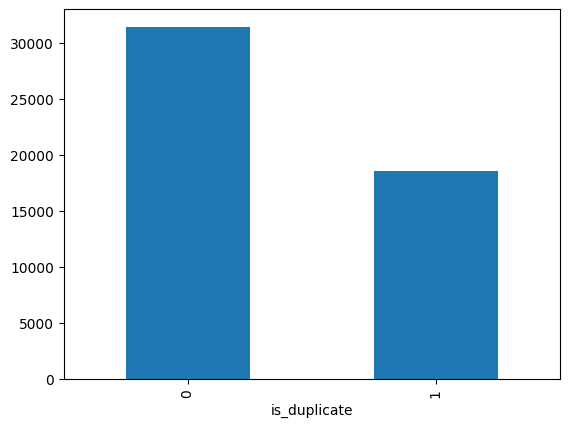

In [12]:
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [13]:
df.head()

,question1,question2,is_duplicate
141332,What types of sensors are supported/available ...,"If you had a year of time, how would you spend...",0
56118,What are the things that are relatively cheape...,What are some expensive things in India that c...,0
116069,Is mitid valid by government?,Which college is better MITID or upes?,0
293365,Do PSUs still hire from BITS Pilani (consideri...,Why do students from the Pilani campus hate th...,0
194079,Is Bangalore an overrated city for living?,Is Bangalore rapidly becoming the worst city t...,0


In [15]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
stop_words = set(stopwords.words('english'))
len(stop_words)

198

In [17]:
def preprocess(q):

  q = q.strip().lower()
  q = BeautifulSoup(q, 'html.parser').get_text()
  q = re.sub(r'http\S+|www\.\S+', '', q)
  q = ''.join(char for char in q if char not in string.punctuation)

  stop_words = set(stopwords.words('english'))
  q = " ".join([item for item in q.split() if item not in stop_words])

  ps = PorterStemmer()
  q = " ".join([ps.stem(word) for word in q.split()])

  return q


In [20]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [21]:
df.head()

,question1,question2,is_duplicate
141332,type sensor supportedavail today wireless back...,year time would spend,0
56118,thing rel cheaper australia countri like india,expens thing india could purchas australia rel...,0
116069,mitid valid govern,colleg better mitid upe,0
293365,psu still hire bit pilani consid pilani goa hy...,student pilani campu hate counterpart goa hyde...,0
194079,bangalor overr citi live,bangalor rapidli becom worst citi live india,0


In [22]:
df.shape

(50000, 3)

In [23]:
df['q1_num_words'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_num_words'] = df['question2'].apply(lambda x: len(x.split()))

In [24]:
df['q1_len'] = df['question1'].apply(lambda x: len(x))
df['q2_len'] = df['question2'].apply(lambda x: len(x))

In [25]:
def common_words(row):

  q1 = row['question1']
  q2 = row['question2']

  q1 = set(q1.split())
  q2 = set(q2.split())
  return len(q1.intersection(q2))

In [26]:
df['common_words'] = df.apply(common_words, axis=1)

In [27]:
def total_words(row):

  q1 = row['question1']
  q2 = row['question2']

  q1 = set(q1.split())
  q2 = set(q2.split())
  return (len(q1) + len(q2))

In [28]:
df['total_words'] = df.apply(total_words, axis=1)

In [29]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [30]:
df.dropna(inplace=True)

In [31]:
df.head()

,question1,question2,is_duplicate,q1_num_words,q2_num_words,q1_len,q2_len,common_words,total_words,word_share
141332,type sensor supportedavail today wireless back...,year time would spend,0,8,4,66,21,0,12,0.00
56118,thing rel cheaper australia countri like india,expens thing india could purchas australia rel...,0,7,9,46,60,5,16,0.31
116069,mitid valid govern,colleg better mitid upe,0,3,4,18,23,1,7,0.14
293365,psu still hire bit pilani consid pilani goa hy...,student pilani campu hate counterpart goa hyde...,0,9,7,53,51,3,15,0.20
194079,bangalor overr citi live,bangalor rapidli becom worst citi live india,0,4,7,24,44,3,11,0.27


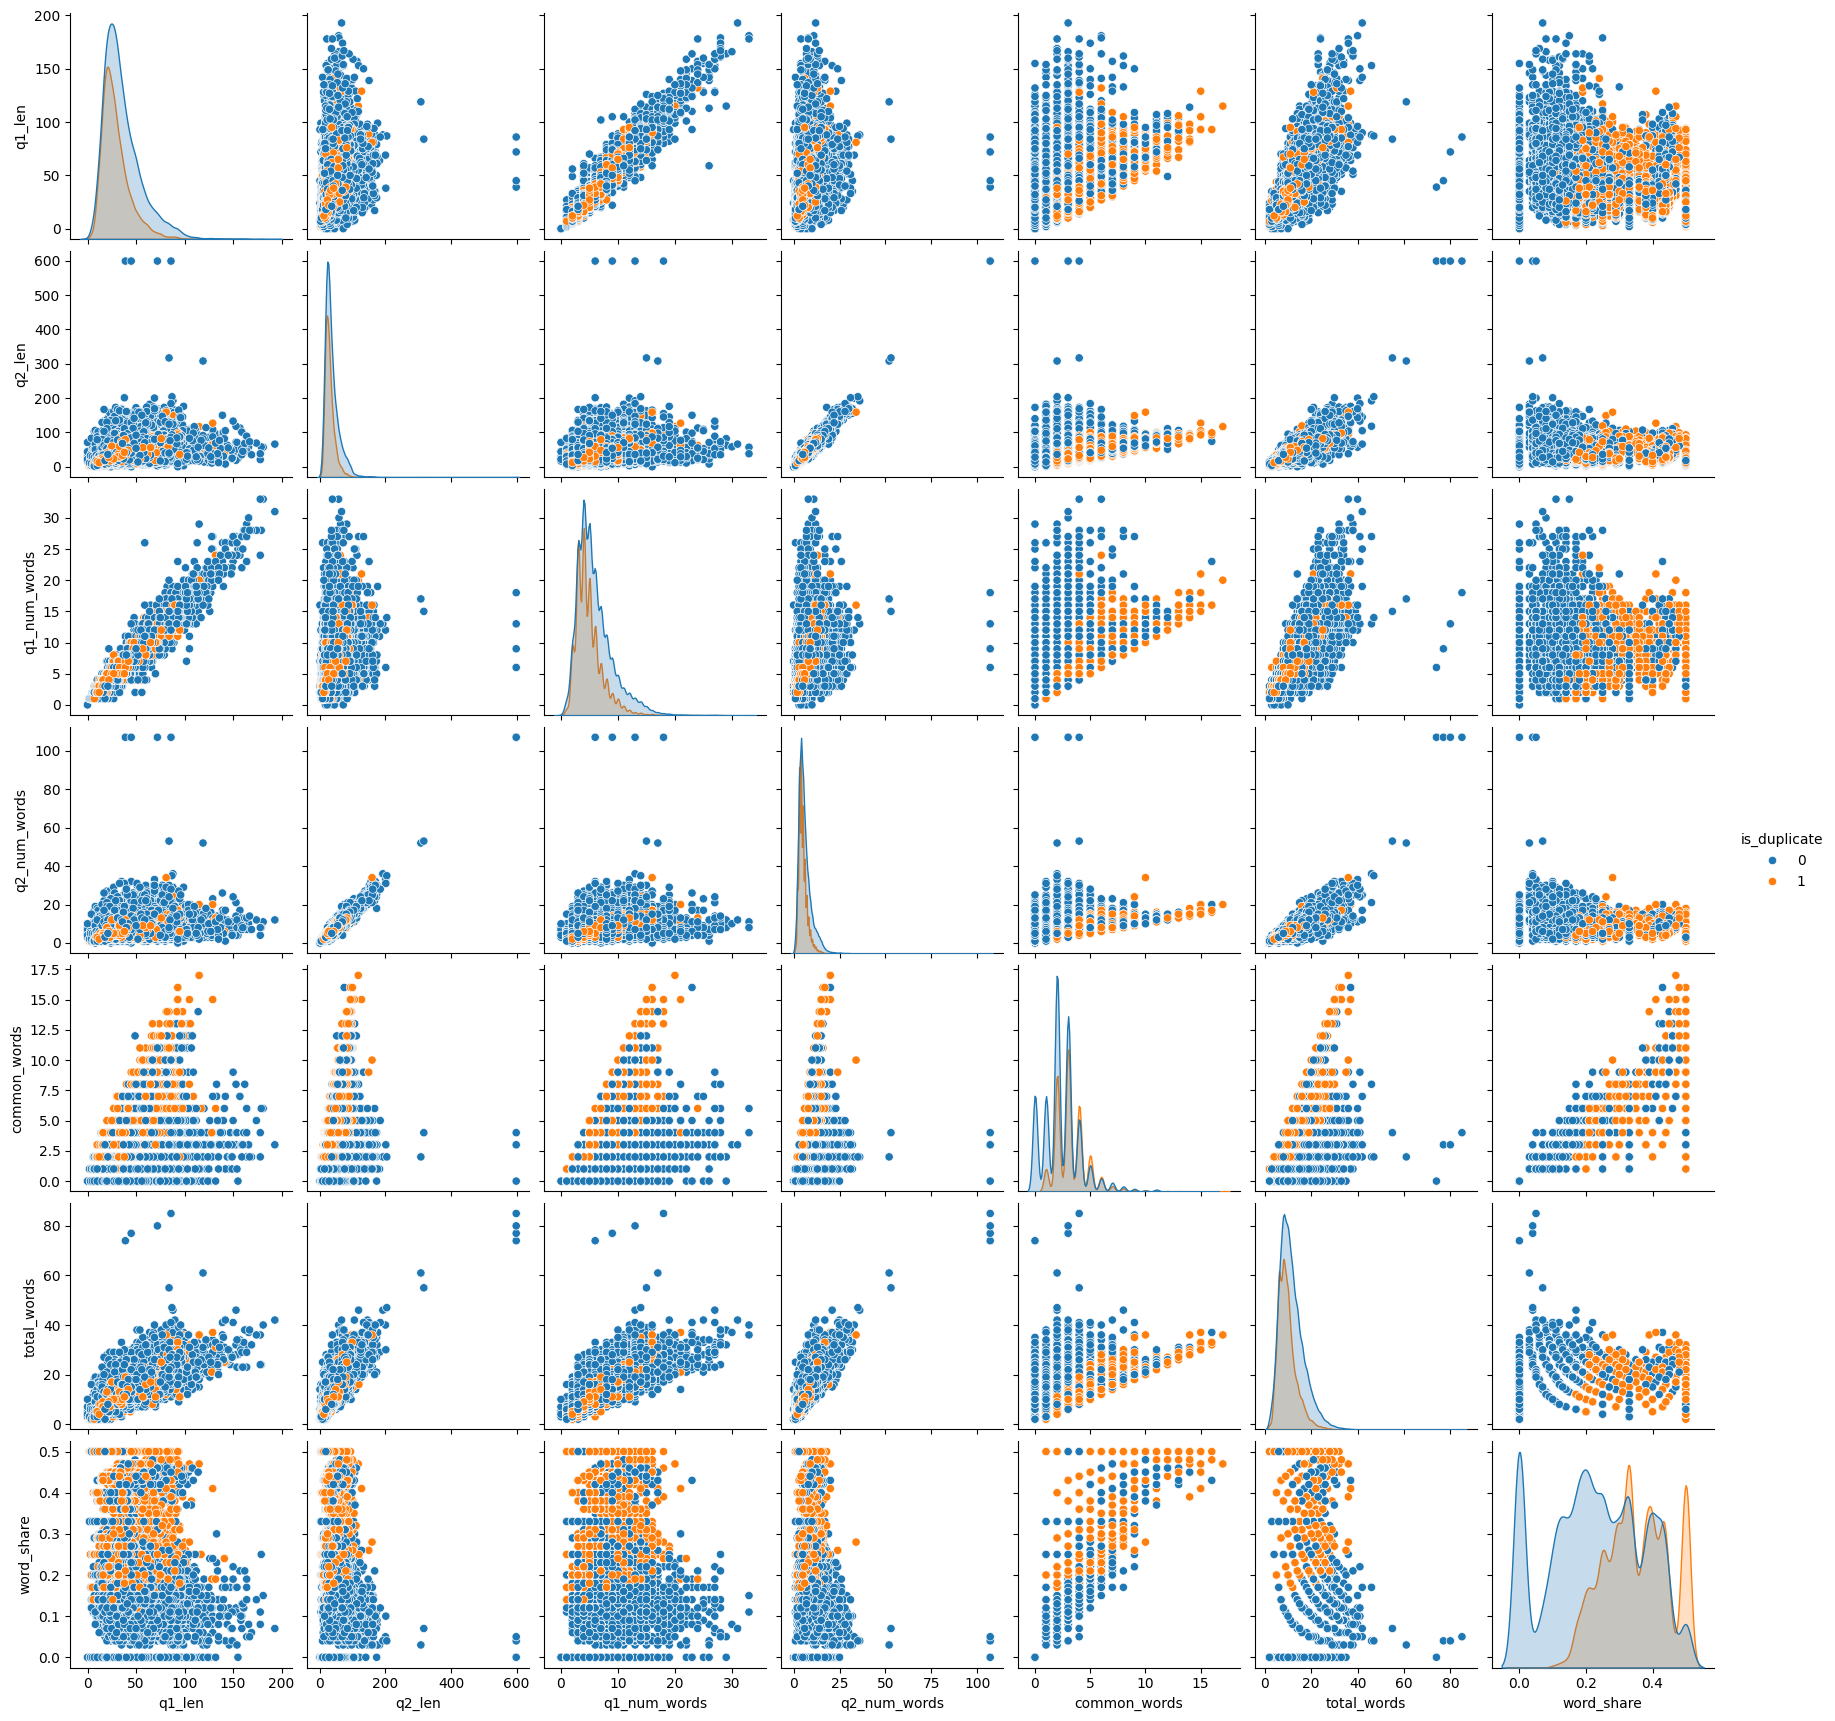

In [32]:
sns.pairplot(df[['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'common_words', 'total_words', 'word_share', 'is_duplicate']], hue='is_duplicate')

In [33]:
cv = CountVectorizer(max_features=3000)

# Fit on all text combined
all_text = pd.concat([df['question1'], df['question2']])
cv.fit(all_text)

# Now transform each column using the same TF-IDF model
q1 = cv.transform(df['question1']).toarray()
q2 = cv.transform(df['question2']).toarray()

In [34]:
q1_df = pd.DataFrame(q1)
q2_df = pd.DataFrame(q2)

q1_df.index = df.index
q2_df.index = df.index

df_combined = pd.concat([df, q1_df, q2_df], axis=1)

In [35]:
df_combined.shape

(49993, 6010)

In [36]:
X = df_combined.drop(columns=['question1', 'question2', 'is_duplicate']).values
y = df_combined['is_duplicate'].values

In [37]:
X.shape

(49993, 6007)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

In [39]:
mnb = MultinomialNB()

In [40]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.7288728872887289
[[5069 1214]
 [1497 2219]]
0.6463734343140111


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=50,    
    max_depth=15          
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6717671767176717
[[6212   71]
 [3211  505]]


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=50,
    max_depth=10
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7652765276527653
[[5498  785]
 [1562 2154]]


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    verbose=-1
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(verbose=-1)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.7698769876987699
[[5437  846]
 [1455 2261]]
